In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import os, sys
from pathlib import Path

import numpy as np
from scipy.stats import spearmanr
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, _tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, make_scorer
import graphviz

import statsmodels.api as sm

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [4]:
results_path = Path('results', 'decision_trees')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [5]:
with pd.HDFStore('data.h5') as store:
    data = store['us/equities/monthly']
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 77788 entries, ('A', Timestamp('2006-12-31 00:00:00')) to ('ZION', Timestamp('2017-11-30 00:00:00'))
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   atr            77788 non-null  float64
 1   bb_down        77788 non-null  float64
 2   bb_high        77788 non-null  float64
 3   bb_low         77788 non-null  float64
 4   bb_mid         77788 non-null  float64
 5   bb_up          77788 non-null  float64
 6   macd           77788 non-null  float64
 7   natr           77788 non-null  float64
 8   rsi            77788 non-null  float64
 9   sector         77788 non-null  object 
 10  return_1m      77788 non-null  float64
 11  return_3m      77788 non-null  float64
 12  return_6m      77788 non-null  float64
 13  return_12m     77788 non-null  float64
 14  beta           77788 non-null  float64
 15  SMB            77788 non-null  float64
 16  HML            7778

In [6]:
X2 = data.loc[:, ['target', 'return_1m']]
X2.columns = ['y', 't-1']
X2['t-2'] = data.groupby(level='ticker').return_1m.shift()
X2 = X2.dropna()
X2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 77176 entries, ('A', Timestamp('2007-01-31 00:00:00')) to ('ZION', Timestamp('2017-11-30 00:00:00'))
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       77176 non-null  float64
 1   t-1     77176 non-null  float64
 2   t-2     77176 non-null  float64
dtypes: float64(3)
memory usage: 2.1+ MB


In [7]:
X2

y       t-1       t-2
ticker date                                    
A      2007-01-31 -0.007812 -0.081779  0.094535
       2007-02-28  0.061102 -0.007812 -0.081779
       2007-03-31  0.020184  0.061102 -0.007812
       2007-04-30  0.110562  0.020184  0.061102
       2007-05-31  0.007074  0.110562  0.020184
...                     ...       ...       ...
ZION   2017-07-31 -0.034067  0.032111  0.095832
       2017-08-31  0.080623 -0.034067  0.032111
       2017-09-30 -0.015261  0.080623 -0.034067
       2017-10-31  0.066509 -0.015261  0.080623
       2017-11-30  0.025832  0.066509 -0.015261

[77176 rows x 3 columns]

In [8]:
y2 = X2.y
X2 = X2.drop('y', axis=1)

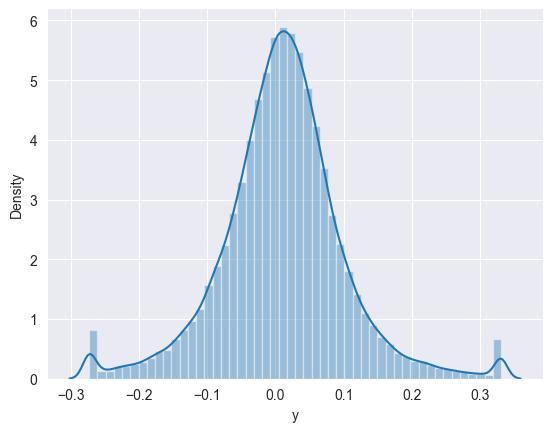

In [9]:
sns.distplot(y2)
sns.despine();

In [10]:
reg_tree_t2 = DecisionTreeRegressor(criterion='mse',
                                    splitter='best',
                                    max_depth=6,
                                    min_samples_split=2,
                                    min_samples_leaf=50,
                                    min_weight_fraction_leaf=0.0,
                                    max_features=None,
                                    random_state=42,
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0,
                                    min_impurity_split=None)

In [11]:
X2

t-1       t-2
ticker date                          
A      2007-01-31 -0.081779  0.094535
       2007-02-28 -0.007812 -0.081779
       2007-03-31  0.061102 -0.007812
       2007-04-30  0.020184  0.061102
       2007-05-31  0.110562  0.020184
...                     ...       ...
ZION   2017-07-31  0.032111  0.095832
       2017-08-31 -0.034067  0.032111
       2017-09-30  0.080623 -0.034067
       2017-10-31 -0.015261  0.080623
       2017-11-30  0.066509 -0.015261

[77176 rows x 2 columns]

In [12]:
%%timeit
reg_tree_t2.fit(X=X2, y=y2)

77.3 ms ± 205 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
out_file = results_path / 'reg_tree_t2.dot'
dot_data = export_graphviz(reg_tree_t2,
                          out_file=out_file.as_posix(),
                          feature_names=X2.columns,
                          max_depth=2,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

In [14]:
ols_model = sm.OLS(endog=y2, exog=sm.add_constant(X2))

In [15]:
%%timeit
ols_model.fit()

65.9 µs ± 2.49 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [16]:
result = ols_model.fit()

In [17]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     31.83
Date:                Fri, 03 Mar 2023   Prob (F-statistic):           1.53e-14
Time:                        16:04:52   Log-Likelihood:                 75823.
No. Observations:               77176   AIC:                        -1.516e+05
Df Residuals:                   77173   BIC:                        -1.516e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0100      0.000     30.232      0.0

In [18]:
lin_reg = LinearRegression()

In [19]:
%%timeit
lin_reg.fit(X=X2, y=y2)

2.76 ms ± 417 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
lin_reg.intercept_

0.009971254720772654

In [21]:
print(lin_reg.coef_)


[ 0.02269243 -0.01794206]


In [22]:
t1, t2 = np.meshgrid(np.linspace(X2['t-1'].quantile(.01), X2['t-1'].quantile(.99), 100),
                     np.linspace(X2['t-2'].quantile(.01), X2['t-2'].quantile(.99), 100))
X_data = np.c_[t1.ravel(), t2.ravel()]

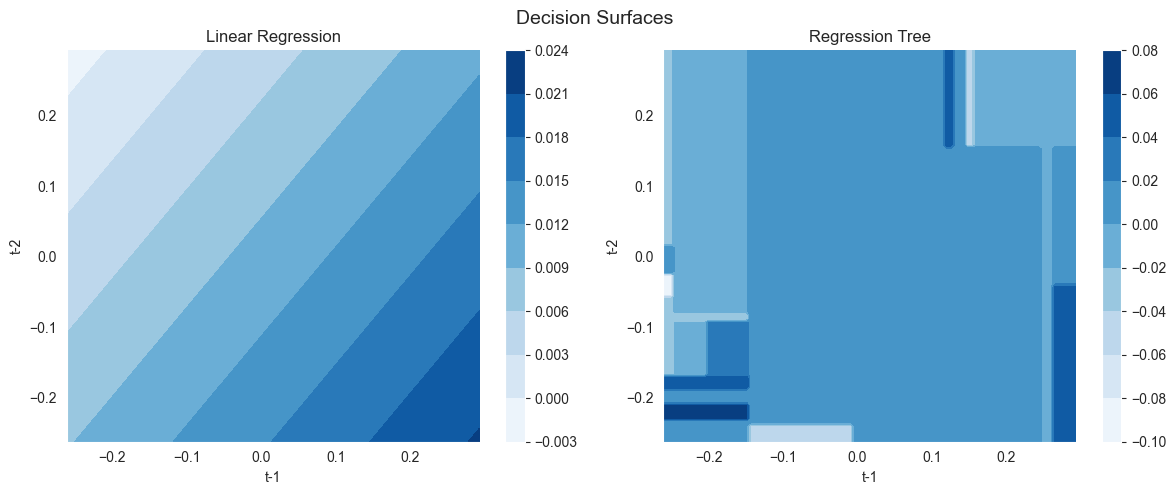

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
ret1 = lin_reg.predict(X_data).reshape(t1.shape)
surface1 = axes[0].contourf(t1, t2, ret1, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
ret2 = reg_tree_t2.predict(X_data).reshape(t1.shape)
surface2 = axes[1].contourf(t1, t2, ret2, cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Linear Regression', 'Regression Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('t-1')
    ax.set_ylabel('t-2')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);

In [24]:
def entropy(f):
    return (-f*np.log2(f) - (1-f)*np.log2(1-f))/2

def gini(f):
    return 2*f*(1-f)

def misclassification_rate(f):
    return np.where(f<=.5, f, 1-f)

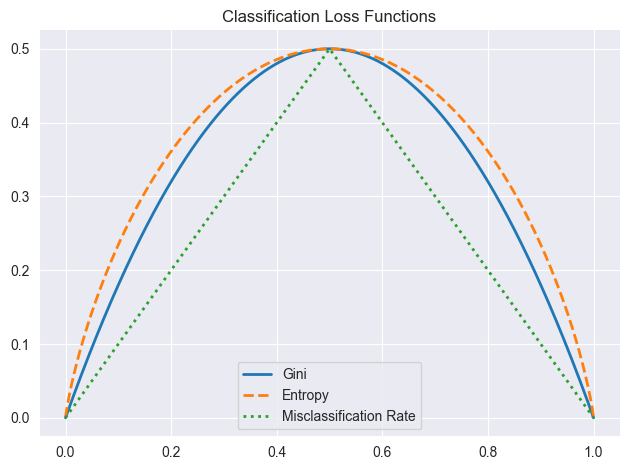

In [25]:
x = np.linspace(0, 1, 10000)
(pd.DataFrame({'Gini': gini(x),
              'Entropy': entropy(x),
             'Misclassification Rate': misclassification_rate(x)}, index=x)
 .plot(title='Classification Loss Functions', lw=2, style=['-', '--', ':']))
sns.despine()
plt.tight_layout();

In [26]:
clf_tree_t2 = DecisionTreeClassifier(criterion='gini',
                                     splitter='best',
                                     max_depth=5,
                                     min_samples_split=1000,
                                     min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0,
                                     max_features=None,
                                     random_state=42,
                                     max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     class_weight=None)

In [27]:
y_binary = (y2>0)*1
y_binary.value_counts()

1    43399
0    33777
Name: y, dtype: int64

In [28]:
%%timeit
clf_tree_t2.fit(X=X2, y=y_binary)

78.2 ms ± 236 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
clf_tree_t2.fit(X=X2, y=y_binary)

DecisionTreeClassifier(max_depth=5, min_samples_split=1000, random_state=42)

In [30]:
out_file = results_path / 'clf_tree_t2.dot'
dot_data = export_graphviz(clf_tree_t2,
                           out_file=out_file.as_posix(),
                           feature_names=X2.columns,
                           class_names=['Down', 'Up'],
                           max_depth=2,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

In [31]:
# compare with logistic regression
#Statsmodels
log_reg_sm = sm.Logit(endog=y_binary, exog=sm.add_constant(X2))

In [32]:
%%timeit
log_reg_sm.fit(disp=False)

16.4 ms ± 284 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
log_result = log_reg_sm.fit()

Optimization terminated successfully.
         Current function value: 0.685278
         Iterations 4


In [34]:
print(log_result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                77176
Model:                          Logit   Df Residuals:                    77173
Method:                           MLE   Df Model:                            2
Date:                Fri, 03 Mar 2023   Pseudo R-squ.:               0.0001127
Time:                        16:07:02   Log-Likelihood:                -52887.
converged:                       True   LL-Null:                       -52893.
Covariance Type:            nonrobust   LLR p-value:                  0.002584
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2485      0.007     33.873      0.000       0.234       0.263
t-1            0.2712      0.080      3.394      0.001       0.115       0.428
t-2           -0.0560      0.080     -0.701      0.4

In [35]:
log_reg_sk = LogisticRegression()

In [36]:
%%timeit
log_reg_sk.fit(X=X2, y=y_binary)

49.8 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
log_reg_sk.fit(X=X2, y=y_binary)

LogisticRegression()

In [38]:
log_reg_sk.coef_

array([[ 0.26951533, -0.05558622]])

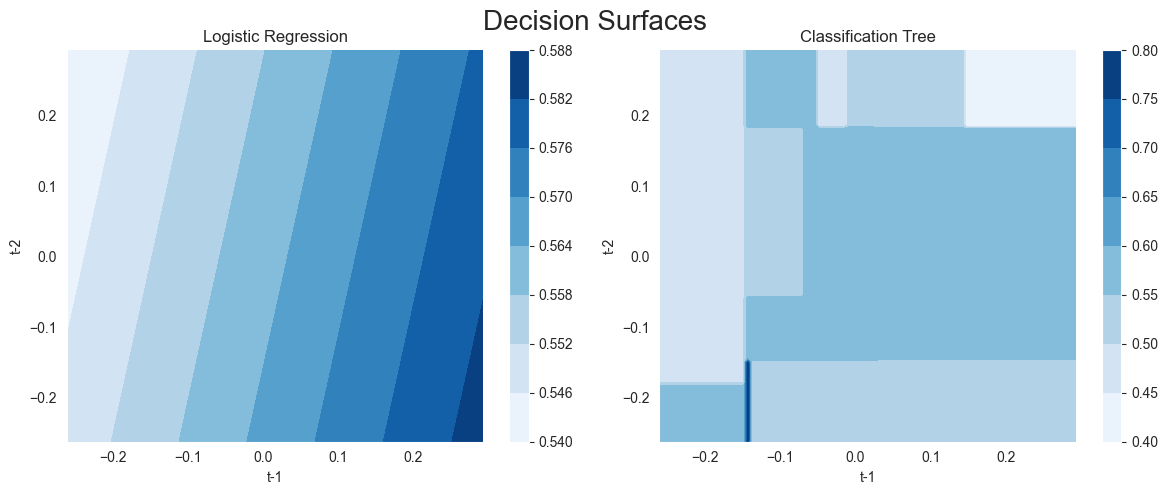

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
ret1 = log_reg_sk.predict_proba(X_data)[:, 1].reshape(t1.shape)
surface1 = axes[0].contourf(t1, t2, ret1, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
ret2 = clf_tree_t2.predict_proba(X_data)[:, 1].reshape(t1.shape)
surface2 = axes[1].contourf(t1, t2, ret2, cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Logistic Regression', 'Classification Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('t-1')
    ax.set_ylabel('t-2')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=20)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);

In [40]:
X = pd.get_dummies(data.drop('target', axis=1))
y = data.target

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
regression_tree = DecisionTreeRegressor(criterion='mse',
                                        splitter='best',
                                        max_depth=5,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None,
                                        random_state=42,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None)

In [43]:
regression_tree.fit(X=X_train, y=y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [44]:
y_pred = regression_tree.predict(X_test)

In [45]:
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))

0.08659823080682824

In [46]:
r, p = spearmanr(y_pred, y_test)
print(f'{r*100:.2f} (p-value={p:.2%})')

18.95 (p-value=0.00%)


In [47]:
y_binary = (y>0).astype(int)
y_binary.value_counts()

1    43733
0    34055
Name: target, dtype: int64

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [49]:
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=5,
                             random_state=42)

In [50]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [51]:

y_score = clf.predict_proba(X=X_test)[:, 1]

In [52]:
y_score

array([0.50603962, 0.50603962, 0.55805243, ..., 0.68817204, 0.63099631,
       0.37479839])

In [53]:
clf.predict_proba(X=X_test)

array([[0.49396038, 0.50603962],
       [0.49396038, 0.50603962],
       [0.44194757, 0.55805243],
       ...,
       [0.31182796, 0.68817204],
       [0.36900369, 0.63099631],
       [0.62520161, 0.37479839]])

In [54]:
roc_auc_score(y_score=y_score, y_true=y_test)

0.6162765470832821

In [55]:
def tree_to_code(tree, feature_names):
    if isinstance(tree, DecisionTreeClassifier):
        model = 'clf'
    elif isinstance(tree, DecisionTreeRegressor):
        model = 'reg'
    else:
        raise ValueError('Need Regression or Classification Tree')

    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(indent, f'if {name} <= {threshold:.2%}')
            recurse(tree_.children_left[node], depth + 1)
            print(indent, f'else:  # if {name} > {threshold:.2%}')
            recurse(tree_.children_right[node], depth + 1)
        else:
            pred = tree_.value[node][0]
            val = pred[1]/sum(pred) if model == 'clf' else pred[0]
            print(indent, f'return {val:.2%}')
    recurse(0, 1)

In [56]:

tree_to_code(clf_tree_t2, X2.columns)

def tree(t-1, t-2):
   if t-1 <= -14.64%
     if t-2 <= -17.93%
       return 55.84%
     else:  # if t-2 > -17.93%
       if t-1 <= -26.16%
         return 41.08%
       else:  # if t-1 > -26.16%
         if t-1 <= -26.14%
           return 100.00%
         else:  # if t-1 > -26.14%
           if t-1 <= -14.66%
             return 49.09%
           else:  # if t-1 > -14.66%
             return 0.00%
   else:  # if t-1 > -14.64%
     if t-2 <= 18.14%
       if t-2 <= -14.83%
         if t-2 <= -14.85%
           if t-1 <= -14.31%
             return 77.78%
           else:  # if t-1 > -14.31%
             return 52.24%
         else:  # if t-2 > -14.85%
           return 0.00%
       else:  # if t-2 > -14.83%
         if t-1 <= -6.59%
           if t-2 <= -6.04%
             return 58.58%
           else:  # if t-2 > -6.04%
             return 53.78%
         else:  # if t-1 > -6.59%
           if t-1 <= 2.68%
             return 58.02%
           else:  # if t-1 > 2.68%
             r

In [57]:
n_splits = 10
train_period_length = 60
test_period_length = 6
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

In [58]:

max_depths = range(1, 16)

In [80]:
# Finding the best trees using GridSearchCV
param_grid = {'max_depth': [2,3,4,5,6,7,8,10,12,15],
              'min_samples_leaf': [5, 25, 50, 100],
              'max_features': ['sqrt', 'auto']}

In [81]:
clf = DecisionTreeClassifier(random_state=42)

In [82]:
gridsearch_clf = GridSearchCV(estimator=clf,
                              param_grid=param_grid,
                              scoring='roc_auc',
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True)

In [83]:
gridsearch_clf.fit(X=X, y=y_binary)

GridSearchCV(cv=<utils.MultipleTimeSeriesCV object at 0x000001FE6A9157C0>,
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12, 15],
                         'max_features': ['sqrt', 'auto'],
                         'min_samples_leaf': [5, 25, 50, 100]},
             return_train_score=True, scoring='roc_auc')

In [84]:
gridsearch_clf.best_params_

{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 100}

In [64]:

gridsearch_clf.best_score_

0.5276523209690385

In [65]:
def rank_correl(y, y_pred):
    return spearmanr(y, y_pred)[0]
ic = make_scorer(rank_correl)

In [66]:
reg_tree = DecisionTreeRegressor(random_state=42)

In [67]:
gridsearch_reg = GridSearchCV(estimator=reg_tree,
                              param_grid=param_grid,
                              scoring=ic,
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True)

In [68]:
gridsearch_reg.fit(X=X, y=y)

GridSearchCV(cv=<utils.MultipleTimeSeriesCV object at 0x000001FE6A9157C0>,
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12, 15],
                         'max_features': ['sqrt', 'auto'],
                         'min_samples_leaf': [5, 25, 50, 100]},
             return_train_score=True, scoring=make_scorer(rank_correl))

In [69]:
gridsearch_reg.best_params_

{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 5}

In [70]:
pd.DataFrame({'Regression': pd.Series(gridsearch_reg.best_params_),
              'Classification': pd.Series(gridsearch_clf.best_params_)})

,Regression,Classification
max_depth,8,15
max_features,sqrt,sqrt
min_samples_leaf,5,100


In [74]:
clf.tree_

AttributeError: 'DecisionTreeClassifier' object has no attribute 'tree_'

In [78]:
def get_leaves_count(tree):
    t = tree.tree_
    n = t.node_count
    leaves = len([i for i in range(t.node_count) if t.children_left[i]== -1])
    return leaves

In [85]:
train_scores, val_scores, leaves = {}, {}, {}
for max_depth in max_depths:
    print(max_depth, end=' ', flush=True)
    clf = DecisionTreeClassifier(criterion='gini',
                                 max_depth=max_depth,
                                 min_samples_leaf=5,
                                 max_features='sqrt',
                                 random_state=42)
    train_scores[max_depth], val_scores[max_depth], leaves[max_depth] = [], [], []
    for train_idx, test_idx in cv.split(X):
        X_train, y_train,  = X.iloc[train_idx], y_binary.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y_binary.iloc[test_idx]
        clf.fit(X=X_train, y=y_train)

        train_pred = clf.predict_proba(X=X_train)[:, 1]
        train_score = roc_auc_score(y_score=train_pred, y_true=y_train)
        train_scores[max_depth].append(train_score)

        test_pred = clf.predict_proba(X=X_test)[:, 1]
        val_score = roc_auc_score(y_score=test_pred, y_true=y_test)
        val_scores[max_depth].append(val_score)
        leaves[max_depth].append(get_leaves_count(clf))

clf_train_scores = pd.DataFrame(train_scores)
clf_valid_scores = pd.DataFrame(val_scores)
clf_leaves = pd.DataFrame(leaves)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 

In [86]:
clf_cv_data = pd.concat([pd.melt(clf_train_scores,
                                 var_name='Max. Depth',
                                 value_name='ROC AUC').assign(Data='Train'),
                         pd.melt(clf_valid_scores,
                                 var_name='Max. Depth',
                                 value_name='ROC AUC').assign(Data='Valid')])

In [87]:
clf_cv_data

,Max. Depth,ROC AUC,Data
0,1,0.543558,Train
1,1,0.546418,Train
2,1,0.535052,Train
3,1,0.533757,Train
4,1,0.519159,Train
...,...,...,...
145,15,0.549773,Valid
146,15,0.480058,Valid
147,15,0.459461,Valid
148,15,0.527562,Valid


In [88]:
train_scores, val_scores, leaves = {}, {}, {}
for max_depth in max_depths:
    print(max_depth, end=' ', flush=True)
    reg_tree = DecisionTreeRegressor(max_depth=max_depth,
                                     min_samples_leaf=50,
                                     max_features= 'sqrt',
                                     random_state=42)
    train_scores[max_depth], val_scores[max_depth], leaves[max_depth] = [], [], []
    for train_idx, test_idx in cv.split(X):
        X_train, y_train,  = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        reg_tree.fit(X=X_train, y=y_train)

        train_pred = reg_tree.predict(X=X_train)
        train_score = spearmanr(train_pred, y_train)[0]
        train_scores[max_depth].append(train_score)

        test_pred = reg_tree.predict(X=X_test)
        val_score = spearmanr(test_pred, y_test)[0]
        val_scores[max_depth].append(val_score)
        leaves[max_depth].append(get_leaves_count(reg_tree))

reg_train_scores = pd.DataFrame(train_scores)
reg_valid_scores = pd.DataFrame(val_scores)
reg_leaves = pd.DataFrame(leaves)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 

In [92]:
reg_cv_data = (pd.melt(reg_train_scores, var_name='Max. Depth',
                         value_name='IC').assign(Data='Train').append(pd.melt(reg_valid_scores,var_name='Max. Depth',value_name='IC').assign(Data='Valid')))

In [94]:
reg_cv_data

,Max. Depth,IC,Data
0,1,0.087718,Train
1,1,0.079533,Train
2,1,0.064190,Train
3,1,0.077128,Train
4,1,0.107183,Train
...,...,...,...
145,15,0.042145,Valid
146,15,-0.068175,Valid
147,15,-0.032448,Valid
148,15,0.057003,Valid


ValueError: cannot reindex from a duplicate axis

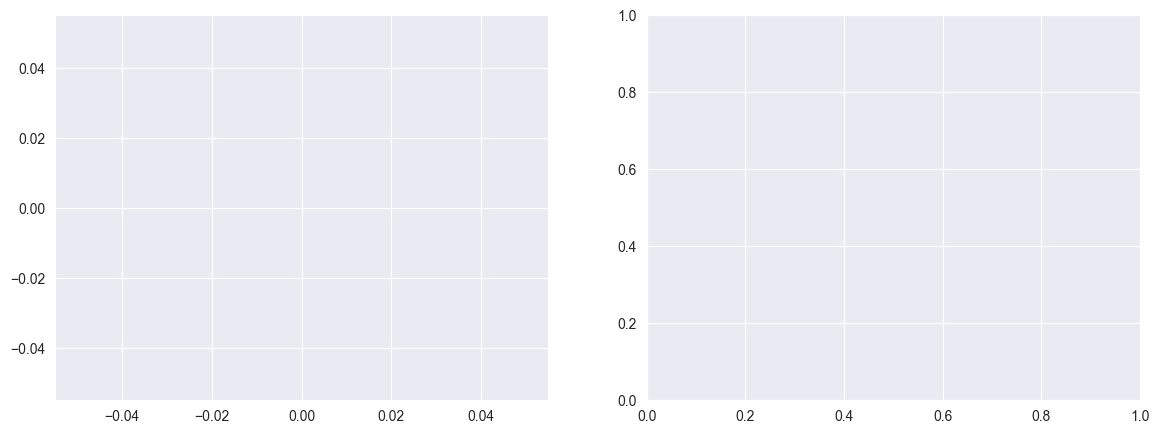

In [93]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.lineplot(data=reg_cv_data,
             x='Max. Depth', y='IC',
             hue='Data', ci=95,
             ax=axes[0], lw=2)

axes[0].set_title('Regression Tree')
axes[0].axvline(x=reg_valid_scores.mean().idxmax(), ls='--', c='k', lw=1)
axes[0].axhline(y=0, ls='--', c='k', lw=1)

sns.lineplot(data=clf_cv_data,
             x='Max. Depth', y='ROC AUC',
             hue='Data', ci=95,
             ax=axes[1], lw=2)

axes[1].set_title('Classification Tree')
axes[1].axvline(x=clf_valid_scores.mean().idxmax(), ls='--', c='k', lw=1)
axes[1].axhline(y=.5, ls='--', c='k', lw=1)
for ax in axes:
    ax.set_xlim(min(param_grid['max_depth']),
                max(param_grid['max_depth']))

fig.suptitle(f'Train-Validation Scores', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.91)

In [95]:
#plot learning curve
sizes = np.arange(.1, 1.01, .1)
train_sizes, train_scores, valid_scores = learning_curve(gridsearch_clf.best_estimator_,
                                                         X,
                                                         y_binary,
                                                         train_sizes=sizes,
                                                         cv=cv,
                                                         scoring='roc_auc',
                                                         n_jobs=-1,
                                                         shuffle=True,
                                                         random_state=42)

In [96]:
clf_lc_data = pd.concat([
    pd.melt(pd.DataFrame(train_scores.T, columns=train_sizes),
            var_name='Train Size',
            value_name='ROC AUC').assign(Data='Train'),
    pd.melt(pd.DataFrame(valid_scores.T, columns=train_sizes),
            var_name='Train Size',
            value_name='ROC AUC').assign(Data='Valid')])
clf_lc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Train Size  200 non-null    int64  
 1   ROC AUC     200 non-null    float64
 2   Data        200 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 6.2+ KB


In [97]:
train_sizes, train_scores, valid_scores = learning_curve(gridsearch_reg.best_estimator_,
                                                         X, y,
                                                         train_sizes=sizes,
                                                         cv=cv,
                                                         scoring=ic,
                                                         n_jobs=-1,
                                                         shuffle=True,
                                                         random_state=42)

In [98]:
reg_lc_data = pd.concat([
    pd.melt(pd.DataFrame(train_scores.T,
                         columns=train_sizes),
            var_name='Train Size',
            value_name='IC').assign(Data='Train'),
    pd.melt(pd.DataFrame(valid_scores.T,
                         columns=train_sizes),
            var_name='Train Size',
            value_name='IC').assign(Data='Valid')])
reg_lc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Train Size  200 non-null    int64  
 1   IC          200 non-null    float64
 2   Data        200 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 6.2+ KB


ValueError: cannot reindex from a duplicate axis

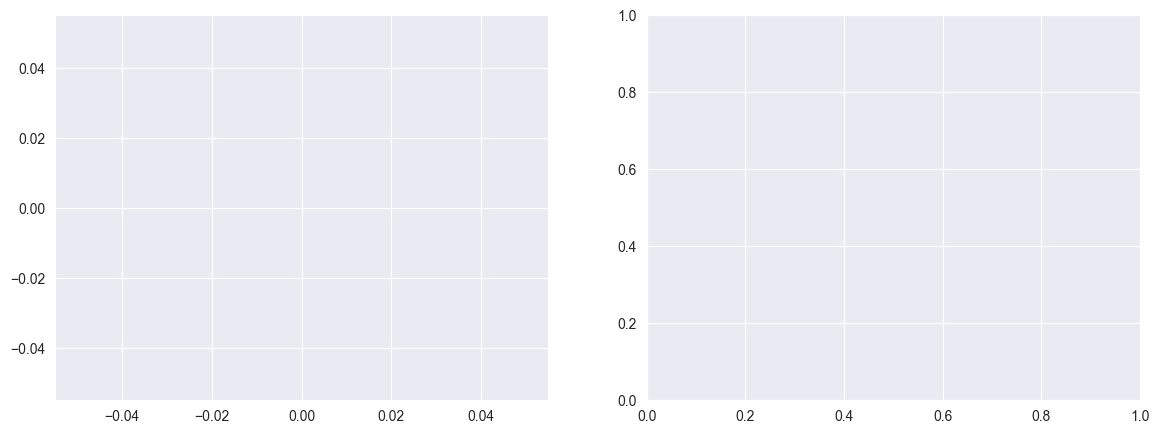

In [99]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
xmin, xmax = reg_lc_data['Train Size'].min(), reg_lc_data['Train Size'].max()

sns.lineplot(data=reg_lc_data,
             x='Train Size', y='IC',
             hue='Data', ci=95,  ax=axes[0], lw=2)
axes[0].set_title('Best Regression Tree')
axes[0].set_ylabel('IC')

axes[0].xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

sns.lineplot(data=clf_lc_data,
             x='Train Size',
             y='ROC AUC',
             hue='Data',
             ci=95,
             ax=axes[1],
             lw=2)
axes[1].set_title('Best Classification Tree')
axes[1].set_ylabel('ROC AUC')
axes[1].xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

for i in [0, 1]:
    axes[i].tick_params(axis='both', which='major', labelsize=10)
    axes[i].tick_params(axis='both', which='minor', labelsize=8)
    axes[i].set_xlim(xmin, xmax)

fig.suptitle('Learning Curves', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

In [100]:
top_n = 15
labels = X.columns.str.replace('_', ' ').str.upper()
fi_clf = (pd.Series(gridsearch_clf.best_estimator_.feature_importances_,
                    index=labels).sort_values(ascending=False).iloc[:top_n])
fi_reg = (pd.Series(gridsearch_reg.best_estimator_.feature_importances_,
                    index=labels).sort_values(ascending=False).iloc[:top_n])

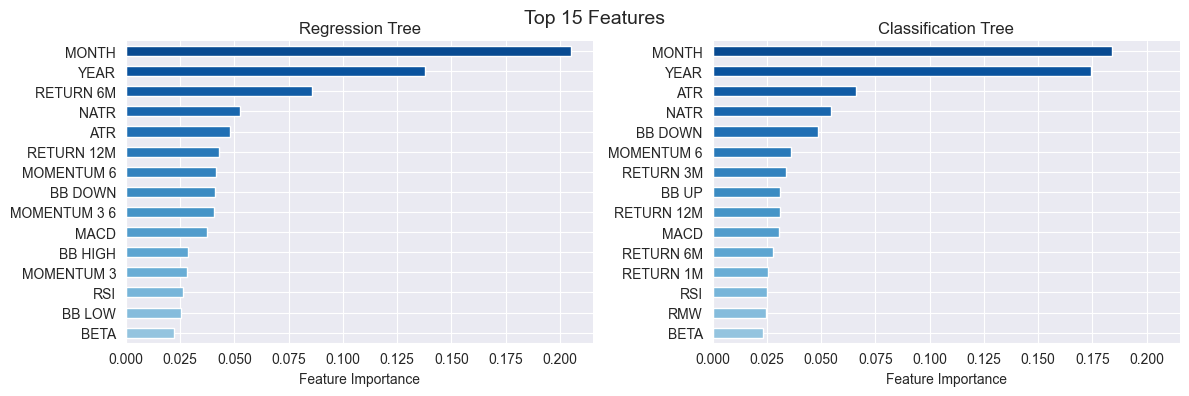

In [101]:
fig, axes= plt.subplots(ncols=2, figsize=(12,4), sharex=True)
color = cm.Blues(np.linspace(.4,.9, top_n))
fi_clf.sort_values().plot.barh(ax=axes[1], title='Classification Tree', color=color)
fi_reg.sort_values().plot.barh(ax=axes[0], title='Regression Tree', color=color)
axes[0].set_xlabel('Feature Importance')
axes[1].set_xlabel('Feature Importance')
fig.suptitle(f'Top {top_n} Features', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);